In [12]:
import tensorflow as tf

tf.__version__

# To generate GIFs

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import numpy as np
import tensorflow as tf
# import tensorflow_datasets as tfds
import keras
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.datasets.cifar10 import load_data
from keras import Model

# from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from IPython import display


In [13]:
BUFFER_SIZE = 6000
BATCH_SIZE = 128
EPOCHS = 100
PRINT_EPOCH = 5
noise_dim = 100
num_examples_to_generate = 16

In [14]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = x_train.reshape(x_train.shape[0], 32, 32, 3).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3).astype('float32')
y_train = y_train.reshape(y_train.shape[0]).astype('int32')
y_test = y_test.reshape(y_test.shape[0]).astype('int32')

label = 3 # Class '3' is cat.
train_indices = np.where(y_train == label) # Get indices of the label
train_set = x_train[train_indices] # Get train samples of the label
test_indices = np.where(y_test == label) # Get indices of the label
test_set = x_train[test_indices] # Get test samples of the label
# Combine the image data
train_images = np.concatenate((train_set, test_set), axis=0)
train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [15]:
def make_generator_model():
    model = tf.keras.Sequential() # Initialize a sequential model for Generator

    # Foundation for 4x4 image
    n_nodes = 256*4*4 # Expected vector size for converting to a feature map
    model.add(layers.Dense(input_shape=(100,), units=n_nodes)) # FC layer to convert latent vector to a vector of size n_nodes
    model.add(layers.LeakyReLU(negative_slope=0.2))
    model.add(layers.Reshape((4, 4, 256)))

    # Upsample to 8x8
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    # model.add(BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(negative_slope=0.2))

    # Upsample to 16x16
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    # model.add(BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(negative_slope=0.2))
    # model.add(BatchNormalization())

    # Upsample to 32x32
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    # model.add(BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(negative_slope=0.2))
    # model.add(BatchNormalization())

    # Convert from 32x32x128 to 32x32x3 conforming to d_model's input
    model.add(layers.Conv2D(3, (3,3), activation='tanh', padding='same'))

    return model

"""Use the (as yet untrained) generator to create an image."""

generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

In [16]:
def make_discriminator_model(in_shape=(32, 32, 3)):
    model = tf.keras.Sequential()
    
    # Block 1 conv
    model.add(layers.Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(layers.LeakyReLU(negative_slope=0.2))
    model.add(Dropout(0.25))

    # Block 2 conv
    model.add(layers.Conv2D(128, (3,3), strides=(2, 2), padding='same'))
    # model.add(BatchNormalization(momentum=0.8))
    # model.add(BatchNormalization())
    model.add(layers.LeakyReLU(negative_slope=0.2))
    model.add(Dropout(0.25))

    # Block 3 conv
    model.add(layers.Conv2D(128, (3,3), strides=(2, 2), padding='same'))
    # model.add(BatchNormalization(momentum=0.8))
    # model.add(BatchNormalization())
    model.add(layers.LeakyReLU(negative_slope=0.2))
    model.add(Dropout(0.25))

    # Block 4 conv
    model.add(layers.Conv2D(256, (3,3), strides=(2, 2), padding='same'))
    # model.add(BatchNormalization(momentum=0.8))
    # model.add(BatchNormalization())
    model.add(layers.LeakyReLU(negative_slope=0.2))
    model.add(Dropout(0.25))

    # Classifier
    # model.add(GlobalMaxPooling2D())
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    return model

"""Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images."""

discriminator = make_discriminator_model()
decision = discriminator(generated_image)

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

"""### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.
"""

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

"""### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.
"""

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

"""The discriminator and the generator optimizers are different since you will train two networks separately."""

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)


In [18]:

"""## Define the training loop

"""

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

"""The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator."""

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
# Training step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss



In [19]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  X_fake = (predictions + 1)/2
  X_fake = (X_fake * 255)
  X_fake = tf.clip_by_value(X_fake, 0, 255)  # Ensure values stay in range
  X_fake = tf.cast(X_fake, tf.uint8)  # Convert to uint8

  # fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      # plt.subplot(4, 4, i+1)
      # plt.imshow(predictions[i, :, :, :] * 127.5 + 127.5)
      # plt.axis('off')
      plt.subplot(4, 4, i+1)
      plt.imshow(X_fake[i])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Epoch 1, Iteration 1/47, D_loss = 1.370, G_loss = 0.693
Epoch 1, Iteration 2/47, D_loss = 1.313, G_loss = 0.691
Epoch 1, Iteration 3/47, D_loss = 1.245, G_loss = 0.687
Epoch 1, Iteration 4/47, D_loss = 1.193, G_loss = 0.678
Epoch 1, Iteration 5/47, D_loss = 1.131, G_loss = 0.655
Epoch 1, Iteration 6/47, D_loss = 1.098, G_loss = 0.610
Epoch 1, Iteration 7/47, D_loss = 1.128, G_loss = 0.528
Epoch 1, Iteration 8/47, D_loss = 1.219, G_loss = 0.449
Epoch 1, Iteration 9/47, D_loss = 1.259, G_loss = 0.428
Epoch 1, Iteration 10/47, D_loss = 1.170, G_loss = 0.485
Epoch 1, Iteration 11/47, D_loss = 1.018, G_loss = 0.605
Epoch 1, Iteration 12/47, D_loss = 0.903, G_loss = 0.745
Epoch 1, Iteration 13/47, D_loss = 0.746, G_loss = 0.916
Epoch 1, Iteration 14/47, D_loss = 0.616, G_loss = 1.119
Epoch 1, Iteration 15/47, D_loss = 0.540, G_loss = 1.300
Epoch 1, Iteration 16/47, D_loss = 0.472, G_loss = 1.479
Epoch 1, Iteration 17/47, D_loss = 0.400, G_loss = 2.107
Epoch 1, Iteration 18/47, D_loss = 0.289

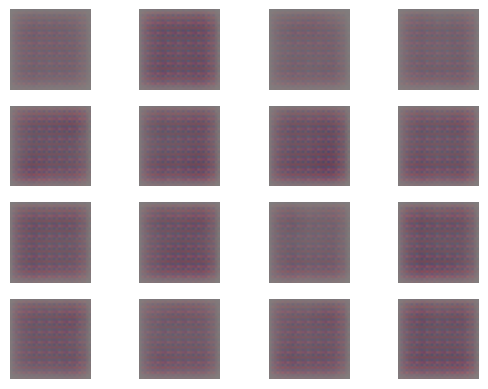

Time for epoch 1 is 8.028489828109741 sec
Epoch 2, Iteration 1/47, D_loss = 0.823, G_loss = 0.667
Epoch 2, Iteration 2/47, D_loss = 0.787, G_loss = 0.699
Epoch 2, Iteration 3/47, D_loss = 0.792, G_loss = 0.745
Epoch 2, Iteration 4/47, D_loss = 0.760, G_loss = 0.796
Epoch 2, Iteration 5/47, D_loss = 0.731, G_loss = 0.838
Epoch 2, Iteration 6/47, D_loss = 0.701, G_loss = 0.878
Epoch 2, Iteration 7/47, D_loss = 0.692, G_loss = 0.917
Epoch 2, Iteration 8/47, D_loss = 0.739, G_loss = 0.960
Epoch 2, Iteration 9/47, D_loss = 0.581, G_loss = 0.989
Epoch 2, Iteration 10/47, D_loss = 0.527, G_loss = 1.073
Epoch 2, Iteration 11/47, D_loss = 0.520, G_loss = 1.162
Epoch 2, Iteration 12/47, D_loss = 0.497, G_loss = 1.222
Epoch 2, Iteration 13/47, D_loss = 0.435, G_loss = 1.232
Epoch 2, Iteration 14/47, D_loss = 0.475, G_loss = 1.149
Epoch 2, Iteration 15/47, D_loss = 0.545, G_loss = 1.027
Epoch 2, Iteration 16/47, D_loss = 0.573, G_loss = 0.917
Epoch 2, Iteration 17/47, D_loss = 0.653, G_loss = 0.94

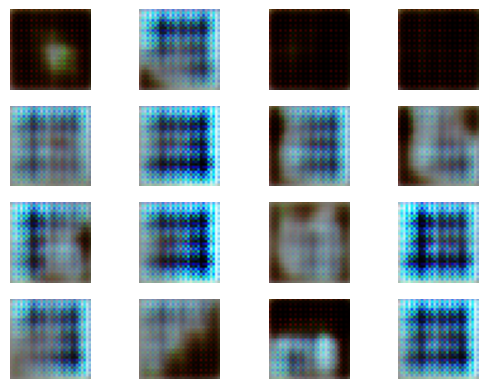

Time for epoch 6 is 4.685736894607544 sec
Epoch 7, Iteration 1/47, D_loss = 1.022, G_loss = 1.210
Epoch 7, Iteration 2/47, D_loss = 0.943, G_loss = 1.185
Epoch 7, Iteration 3/47, D_loss = 0.880, G_loss = 1.224
Epoch 7, Iteration 4/47, D_loss = 0.900, G_loss = 1.235
Epoch 7, Iteration 5/47, D_loss = 0.943, G_loss = 1.145
Epoch 7, Iteration 6/47, D_loss = 1.189, G_loss = 0.751
Epoch 7, Iteration 7/47, D_loss = 1.452, G_loss = 0.709
Epoch 7, Iteration 8/47, D_loss = 1.346, G_loss = 1.972
Epoch 7, Iteration 9/47, D_loss = 1.304, G_loss = 2.483
Epoch 7, Iteration 10/47, D_loss = 1.460, G_loss = 2.314
Epoch 7, Iteration 11/47, D_loss = 1.355, G_loss = 1.830
Epoch 7, Iteration 12/47, D_loss = 1.280, G_loss = 1.560
Epoch 7, Iteration 13/47, D_loss = 1.286, G_loss = 1.762
Epoch 7, Iteration 14/47, D_loss = 1.204, G_loss = 1.614
Epoch 7, Iteration 15/47, D_loss = 1.211, G_loss = 1.664
Epoch 7, Iteration 16/47, D_loss = 1.221, G_loss = 1.629
Epoch 7, Iteration 17/47, D_loss = 1.093, G_loss = 1.49

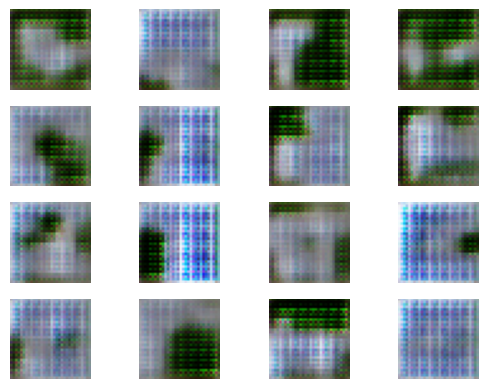

Time for epoch 11 is 4.676934003829956 sec
Epoch 12, Iteration 1/47, D_loss = 1.037, G_loss = 0.933
Epoch 12, Iteration 2/47, D_loss = 1.163, G_loss = 0.742
Epoch 12, Iteration 3/47, D_loss = 1.218, G_loss = 0.809
Epoch 12, Iteration 4/47, D_loss = 1.129, G_loss = 1.200
Epoch 12, Iteration 5/47, D_loss = 1.285, G_loss = 1.401
Epoch 12, Iteration 6/47, D_loss = 1.592, G_loss = 0.908
Epoch 12, Iteration 7/47, D_loss = 1.634, G_loss = 0.767
Epoch 12, Iteration 8/47, D_loss = 1.721, G_loss = 1.028
Epoch 12, Iteration 9/47, D_loss = 1.698, G_loss = 0.901
Epoch 12, Iteration 10/47, D_loss = 1.625, G_loss = 0.767
Epoch 12, Iteration 11/47, D_loss = 1.511, G_loss = 0.831
Epoch 12, Iteration 12/47, D_loss = 1.325, G_loss = 0.896
Epoch 12, Iteration 13/47, D_loss = 1.188, G_loss = 0.985
Epoch 12, Iteration 14/47, D_loss = 1.102, G_loss = 1.047
Epoch 12, Iteration 15/47, D_loss = 1.042, G_loss = 1.135
Epoch 12, Iteration 16/47, D_loss = 0.949, G_loss = 1.127
Epoch 12, Iteration 17/47, D_loss = 0.

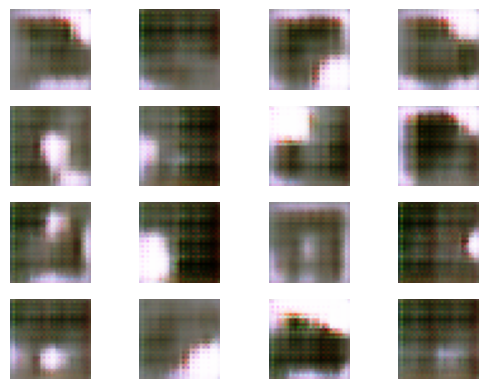

Time for epoch 16 is 4.744567632675171 sec
Epoch 17, Iteration 1/47, D_loss = 1.325, G_loss = 0.820
Epoch 17, Iteration 2/47, D_loss = 1.249, G_loss = 0.841
Epoch 17, Iteration 3/47, D_loss = 1.298, G_loss = 0.858
Epoch 17, Iteration 4/47, D_loss = 1.241, G_loss = 0.873
Epoch 17, Iteration 5/47, D_loss = 1.307, G_loss = 0.889
Epoch 17, Iteration 6/47, D_loss = 1.255, G_loss = 0.914
Epoch 17, Iteration 7/47, D_loss = 1.236, G_loss = 0.976
Epoch 17, Iteration 8/47, D_loss = 1.221, G_loss = 0.994
Epoch 17, Iteration 9/47, D_loss = 1.300, G_loss = 0.952
Epoch 17, Iteration 10/47, D_loss = 1.275, G_loss = 0.981
Epoch 17, Iteration 11/47, D_loss = 1.234, G_loss = 0.996
Epoch 17, Iteration 12/47, D_loss = 1.234, G_loss = 0.977
Epoch 17, Iteration 13/47, D_loss = 1.211, G_loss = 0.972
Epoch 17, Iteration 14/47, D_loss = 1.225, G_loss = 0.959
Epoch 17, Iteration 15/47, D_loss = 1.214, G_loss = 0.958
Epoch 17, Iteration 16/47, D_loss = 1.178, G_loss = 0.976
Epoch 17, Iteration 17/47, D_loss = 1.

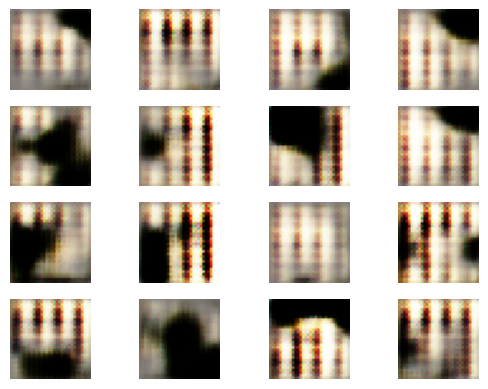

Time for epoch 21 is 4.663532018661499 sec
Epoch 22, Iteration 1/47, D_loss = 0.937, G_loss = 1.465
Epoch 22, Iteration 2/47, D_loss = 0.961, G_loss = 1.413
Epoch 22, Iteration 3/47, D_loss = 1.036, G_loss = 1.404
Epoch 22, Iteration 4/47, D_loss = 1.069, G_loss = 1.498
Epoch 22, Iteration 5/47, D_loss = 1.135, G_loss = 1.529
Epoch 22, Iteration 6/47, D_loss = 1.284, G_loss = 1.976
Epoch 22, Iteration 7/47, D_loss = 1.275, G_loss = 1.608
Epoch 22, Iteration 8/47, D_loss = 1.299, G_loss = 1.578
Epoch 22, Iteration 9/47, D_loss = 1.225, G_loss = 1.574
Epoch 22, Iteration 10/47, D_loss = 1.274, G_loss = 1.394
Epoch 22, Iteration 11/47, D_loss = 1.143, G_loss = 1.256
Epoch 22, Iteration 12/47, D_loss = 1.161, G_loss = 1.346
Epoch 22, Iteration 13/47, D_loss = 1.159, G_loss = 1.321
Epoch 22, Iteration 14/47, D_loss = 1.038, G_loss = 1.334
Epoch 22, Iteration 15/47, D_loss = 0.952, G_loss = 1.512
Epoch 22, Iteration 16/47, D_loss = 0.889, G_loss = 1.543
Epoch 22, Iteration 17/47, D_loss = 0.

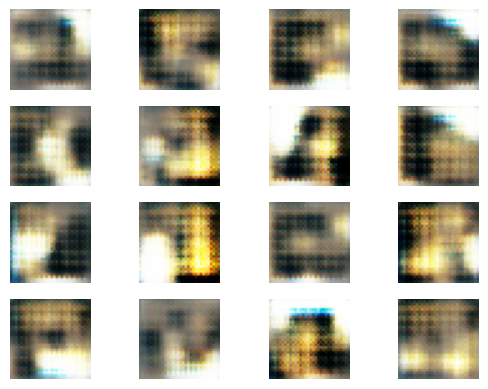

Time for epoch 26 is 4.6911749839782715 sec
Epoch 27, Iteration 1/47, D_loss = 1.265, G_loss = 0.956
Epoch 27, Iteration 2/47, D_loss = 1.193, G_loss = 0.923
Epoch 27, Iteration 3/47, D_loss = 1.204, G_loss = 0.998
Epoch 27, Iteration 4/47, D_loss = 1.197, G_loss = 0.917
Epoch 27, Iteration 5/47, D_loss = 1.145, G_loss = 0.991
Epoch 27, Iteration 6/47, D_loss = 1.130, G_loss = 1.014
Epoch 27, Iteration 7/47, D_loss = 1.151, G_loss = 1.028
Epoch 27, Iteration 8/47, D_loss = 1.080, G_loss = 1.034
Epoch 27, Iteration 9/47, D_loss = 1.200, G_loss = 0.981
Epoch 27, Iteration 10/47, D_loss = 1.314, G_loss = 0.966
Epoch 27, Iteration 11/47, D_loss = 1.276, G_loss = 0.910
Epoch 27, Iteration 12/47, D_loss = 1.240, G_loss = 0.951
Epoch 27, Iteration 13/47, D_loss = 1.210, G_loss = 0.952
Epoch 27, Iteration 14/47, D_loss = 1.236, G_loss = 1.121
Epoch 27, Iteration 15/47, D_loss = 1.202, G_loss = 1.072
Epoch 27, Iteration 16/47, D_loss = 1.194, G_loss = 0.947
Epoch 27, Iteration 17/47, D_loss = 1

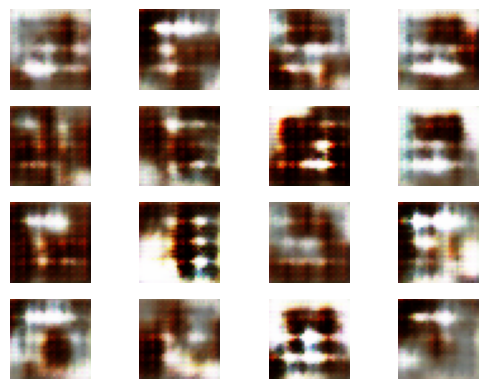

Time for epoch 31 is 4.654534101486206 sec
Epoch 32, Iteration 1/47, D_loss = 1.081, G_loss = 1.110
Epoch 32, Iteration 2/47, D_loss = 1.092, G_loss = 1.142
Epoch 32, Iteration 3/47, D_loss = 1.051, G_loss = 1.238
Epoch 32, Iteration 4/47, D_loss = 1.036, G_loss = 1.190
Epoch 32, Iteration 5/47, D_loss = 0.939, G_loss = 1.169
Epoch 32, Iteration 6/47, D_loss = 0.888, G_loss = 1.363
Epoch 32, Iteration 7/47, D_loss = 0.866, G_loss = 1.386
Epoch 32, Iteration 8/47, D_loss = 0.895, G_loss = 1.365
Epoch 32, Iteration 9/47, D_loss = 0.877, G_loss = 1.116
Epoch 32, Iteration 10/47, D_loss = 0.821, G_loss = 1.688
Epoch 32, Iteration 11/47, D_loss = 0.872, G_loss = 1.364
Epoch 32, Iteration 12/47, D_loss = 0.840, G_loss = 1.278
Epoch 32, Iteration 13/47, D_loss = 0.818, G_loss = 1.226
Epoch 32, Iteration 14/47, D_loss = 1.072, G_loss = 1.691
Epoch 32, Iteration 15/47, D_loss = 1.110, G_loss = 0.678
Epoch 32, Iteration 16/47, D_loss = 0.974, G_loss = 1.744
Epoch 32, Iteration 17/47, D_loss = 1.

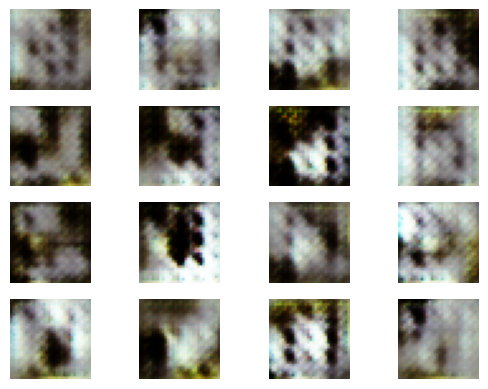

Time for epoch 36 is 4.746523857116699 sec
Epoch 37, Iteration 1/47, D_loss = 1.361, G_loss = 0.830
Epoch 37, Iteration 2/47, D_loss = 1.269, G_loss = 0.816
Epoch 37, Iteration 3/47, D_loss = 1.254, G_loss = 0.898
Epoch 37, Iteration 4/47, D_loss = 1.328, G_loss = 0.923
Epoch 37, Iteration 5/47, D_loss = 1.233, G_loss = 0.897
Epoch 37, Iteration 6/47, D_loss = 1.262, G_loss = 0.874
Epoch 37, Iteration 7/47, D_loss = 1.246, G_loss = 0.922
Epoch 37, Iteration 8/47, D_loss = 1.266, G_loss = 0.983
Epoch 37, Iteration 9/47, D_loss = 1.227, G_loss = 0.940
Epoch 37, Iteration 10/47, D_loss = 1.214, G_loss = 0.967
Epoch 37, Iteration 11/47, D_loss = 1.253, G_loss = 1.057
Epoch 37, Iteration 12/47, D_loss = 1.219, G_loss = 1.037
Epoch 37, Iteration 13/47, D_loss = 1.209, G_loss = 0.991
Epoch 37, Iteration 14/47, D_loss = 1.229, G_loss = 0.977
Epoch 37, Iteration 15/47, D_loss = 1.194, G_loss = 1.016
Epoch 37, Iteration 16/47, D_loss = 1.170, G_loss = 1.023
Epoch 37, Iteration 17/47, D_loss = 1.

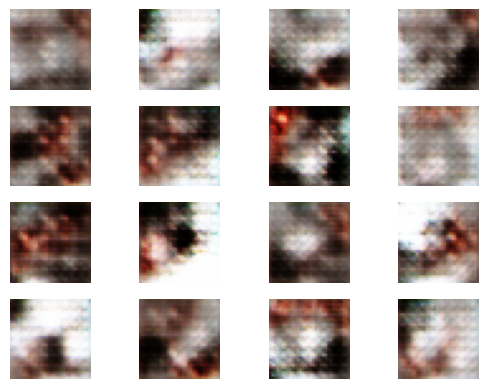

Time for epoch 41 is 4.656556129455566 sec
Epoch 42, Iteration 1/47, D_loss = 1.223, G_loss = 0.936
Epoch 42, Iteration 2/47, D_loss = 1.191, G_loss = 0.926
Epoch 42, Iteration 3/47, D_loss = 1.146, G_loss = 1.017
Epoch 42, Iteration 4/47, D_loss = 1.156, G_loss = 0.995
Epoch 42, Iteration 5/47, D_loss = 1.155, G_loss = 1.097
Epoch 42, Iteration 6/47, D_loss = 1.165, G_loss = 0.925
Epoch 42, Iteration 7/47, D_loss = 1.115, G_loss = 0.975
Epoch 42, Iteration 8/47, D_loss = 1.105, G_loss = 1.113
Epoch 42, Iteration 9/47, D_loss = 1.084, G_loss = 1.028
Epoch 42, Iteration 10/47, D_loss = 1.132, G_loss = 0.982
Epoch 42, Iteration 11/47, D_loss = 1.188, G_loss = 1.176
Epoch 42, Iteration 12/47, D_loss = 1.086, G_loss = 0.872
Epoch 42, Iteration 13/47, D_loss = 1.062, G_loss = 0.975
Epoch 42, Iteration 14/47, D_loss = 1.041, G_loss = 1.158
Epoch 42, Iteration 15/47, D_loss = 1.036, G_loss = 0.983
Epoch 42, Iteration 16/47, D_loss = 1.024, G_loss = 1.014
Epoch 42, Iteration 17/47, D_loss = 1.

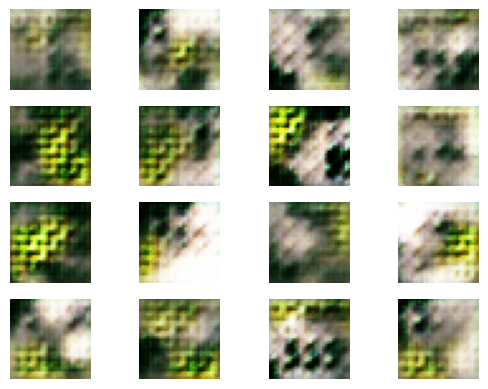

Time for epoch 46 is 4.739558219909668 sec
Epoch 47, Iteration 1/47, D_loss = 1.168, G_loss = 0.980
Epoch 47, Iteration 2/47, D_loss = 1.227, G_loss = 1.007
Epoch 47, Iteration 3/47, D_loss = 1.237, G_loss = 0.998
Epoch 47, Iteration 4/47, D_loss = 1.202, G_loss = 0.993
Epoch 47, Iteration 5/47, D_loss = 1.211, G_loss = 0.954
Epoch 47, Iteration 6/47, D_loss = 1.155, G_loss = 1.094
Epoch 47, Iteration 7/47, D_loss = 1.035, G_loss = 1.053
Epoch 47, Iteration 8/47, D_loss = 1.093, G_loss = 1.119
Epoch 47, Iteration 9/47, D_loss = 0.963, G_loss = 1.053
Epoch 47, Iteration 10/47, D_loss = 1.010, G_loss = 1.118
Epoch 47, Iteration 11/47, D_loss = 0.916, G_loss = 1.079
Epoch 47, Iteration 12/47, D_loss = 0.990, G_loss = 1.044
Epoch 47, Iteration 13/47, D_loss = 0.916, G_loss = 0.980
Epoch 47, Iteration 14/47, D_loss = 0.957, G_loss = 1.172
Epoch 47, Iteration 15/47, D_loss = 1.102, G_loss = 1.026
Epoch 47, Iteration 16/47, D_loss = 1.174, G_loss = 0.765
Epoch 47, Iteration 17/47, D_loss = 1.

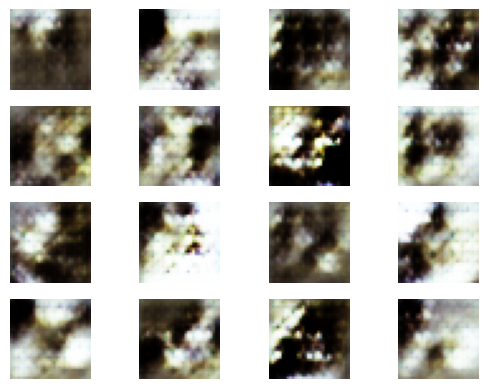

Time for epoch 51 is 4.666115999221802 sec
Epoch 52, Iteration 1/47, D_loss = 1.174, G_loss = 1.094
Epoch 52, Iteration 2/47, D_loss = 1.277, G_loss = 1.094
Epoch 52, Iteration 3/47, D_loss = 1.351, G_loss = 0.819
Epoch 52, Iteration 4/47, D_loss = 1.428, G_loss = 0.752
Epoch 52, Iteration 5/47, D_loss = 1.462, G_loss = 0.847
Epoch 52, Iteration 6/47, D_loss = 1.513, G_loss = 0.754
Epoch 52, Iteration 7/47, D_loss = 1.489, G_loss = 0.696
Epoch 52, Iteration 8/47, D_loss = 1.449, G_loss = 0.708
Epoch 52, Iteration 9/47, D_loss = 1.476, G_loss = 0.748
Epoch 52, Iteration 10/47, D_loss = 1.351, G_loss = 0.681
Epoch 52, Iteration 11/47, D_loss = 1.377, G_loss = 0.712
Epoch 52, Iteration 12/47, D_loss = 1.253, G_loss = 0.749
Epoch 52, Iteration 13/47, D_loss = 1.180, G_loss = 0.794
Epoch 52, Iteration 14/47, D_loss = 1.094, G_loss = 0.837
Epoch 52, Iteration 15/47, D_loss = 1.095, G_loss = 0.893
Epoch 52, Iteration 16/47, D_loss = 0.987, G_loss = 0.949
Epoch 52, Iteration 17/47, D_loss = 1.

2025-03-12 21:00:42.312678: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


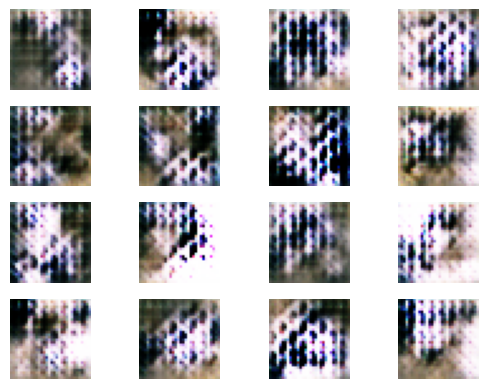

Time for epoch 56 is 4.683889865875244 sec
Epoch 57, Iteration 1/47, D_loss = 0.906, G_loss = 1.455
Epoch 57, Iteration 2/47, D_loss = 0.785, G_loss = 1.546
Epoch 57, Iteration 3/47, D_loss = 0.726, G_loss = 1.686
Epoch 57, Iteration 4/47, D_loss = 0.788, G_loss = 2.337
Epoch 57, Iteration 5/47, D_loss = 0.851, G_loss = 1.810
Epoch 57, Iteration 6/47, D_loss = 0.840, G_loss = 1.614
Epoch 57, Iteration 7/47, D_loss = 0.787, G_loss = 1.975
Epoch 57, Iteration 8/47, D_loss = 1.003, G_loss = 2.016
Epoch 57, Iteration 9/47, D_loss = 1.021, G_loss = 1.189
Epoch 57, Iteration 10/47, D_loss = 1.167, G_loss = 1.078
Epoch 57, Iteration 11/47, D_loss = 1.207, G_loss = 1.056
Epoch 57, Iteration 12/47, D_loss = 1.371, G_loss = 0.891
Epoch 57, Iteration 13/47, D_loss = 1.555, G_loss = 0.921
Epoch 57, Iteration 14/47, D_loss = 1.552, G_loss = 0.682
Epoch 57, Iteration 15/47, D_loss = 1.583, G_loss = 0.589
Epoch 57, Iteration 16/47, D_loss = 1.585, G_loss = 0.542
Epoch 57, Iteration 17/47, D_loss = 1.

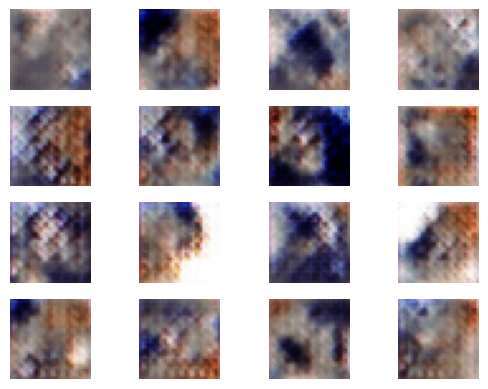

Time for epoch 61 is 4.830331325531006 sec
Epoch 62, Iteration 1/47, D_loss = 1.419, G_loss = 0.912
Epoch 62, Iteration 2/47, D_loss = 1.522, G_loss = 0.811
Epoch 62, Iteration 3/47, D_loss = 1.559, G_loss = 0.692
Epoch 62, Iteration 4/47, D_loss = 1.427, G_loss = 0.650
Epoch 62, Iteration 5/47, D_loss = 1.386, G_loss = 0.697
Epoch 62, Iteration 6/47, D_loss = 1.327, G_loss = 0.759
Epoch 62, Iteration 7/47, D_loss = 1.332, G_loss = 0.718
Epoch 62, Iteration 8/47, D_loss = 1.494, G_loss = 0.727
Epoch 62, Iteration 9/47, D_loss = 1.298, G_loss = 0.684
Epoch 62, Iteration 10/47, D_loss = 1.312, G_loss = 0.701
Epoch 62, Iteration 11/47, D_loss = 1.293, G_loss = 0.739
Epoch 62, Iteration 12/47, D_loss = 1.299, G_loss = 0.731
Epoch 62, Iteration 13/47, D_loss = 1.383, G_loss = 0.741
Epoch 62, Iteration 14/47, D_loss = 1.344, G_loss = 0.709
Epoch 62, Iteration 15/47, D_loss = 1.311, G_loss = 0.721
Epoch 62, Iteration 16/47, D_loss = 1.312, G_loss = 0.720
Epoch 62, Iteration 17/47, D_loss = 1.

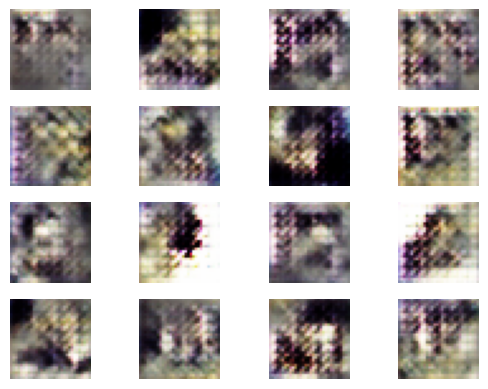

Time for epoch 66 is 4.7060418128967285 sec
Epoch 67, Iteration 1/47, D_loss = 1.416, G_loss = 0.796
Epoch 67, Iteration 2/47, D_loss = 1.264, G_loss = 0.901
Epoch 67, Iteration 3/47, D_loss = 1.104, G_loss = 0.936
Epoch 67, Iteration 4/47, D_loss = 1.032, G_loss = 1.012
Epoch 67, Iteration 5/47, D_loss = 1.036, G_loss = 1.035
Epoch 67, Iteration 6/47, D_loss = 1.083, G_loss = 0.972
Epoch 67, Iteration 7/47, D_loss = 1.013, G_loss = 0.866
Epoch 67, Iteration 8/47, D_loss = 1.078, G_loss = 0.821
Epoch 67, Iteration 9/47, D_loss = 1.100, G_loss = 0.859
Epoch 67, Iteration 10/47, D_loss = 1.189, G_loss = 0.778
Epoch 67, Iteration 11/47, D_loss = 1.219, G_loss = 0.762
Epoch 67, Iteration 12/47, D_loss = 1.248, G_loss = 0.697
Epoch 67, Iteration 13/47, D_loss = 1.357, G_loss = 0.683
Epoch 67, Iteration 14/47, D_loss = 1.323, G_loss = 0.717
Epoch 67, Iteration 15/47, D_loss = 1.321, G_loss = 0.727
Epoch 67, Iteration 16/47, D_loss = 1.309, G_loss = 0.723
Epoch 67, Iteration 17/47, D_loss = 1

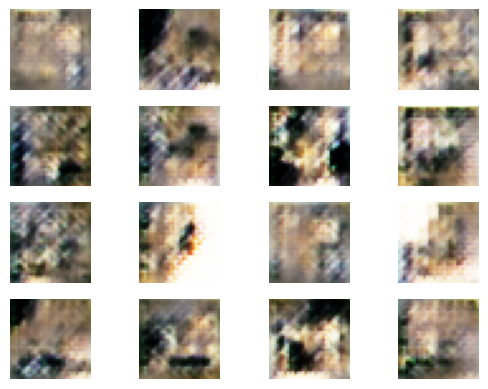

Time for epoch 71 is 4.659060001373291 sec
Epoch 72, Iteration 1/47, D_loss = 1.133, G_loss = 0.865
Epoch 72, Iteration 2/47, D_loss = 1.148, G_loss = 0.918
Epoch 72, Iteration 3/47, D_loss = 1.173, G_loss = 0.922
Epoch 72, Iteration 4/47, D_loss = 1.221, G_loss = 0.861
Epoch 72, Iteration 5/47, D_loss = 1.141, G_loss = 0.873
Epoch 72, Iteration 6/47, D_loss = 1.227, G_loss = 0.852
Epoch 72, Iteration 7/47, D_loss = 1.141, G_loss = 0.832
Epoch 72, Iteration 8/47, D_loss = 1.164, G_loss = 0.839
Epoch 72, Iteration 9/47, D_loss = 1.166, G_loss = 0.907
Epoch 72, Iteration 10/47, D_loss = 1.212, G_loss = 0.894
Epoch 72, Iteration 11/47, D_loss = 1.200, G_loss = 0.873
Epoch 72, Iteration 12/47, D_loss = 1.149, G_loss = 0.836
Epoch 72, Iteration 13/47, D_loss = 1.189, G_loss = 0.848
Epoch 72, Iteration 14/47, D_loss = 1.158, G_loss = 0.923
Epoch 72, Iteration 15/47, D_loss = 1.139, G_loss = 0.916
Epoch 72, Iteration 16/47, D_loss = 1.238, G_loss = 0.818
Epoch 72, Iteration 17/47, D_loss = 1.

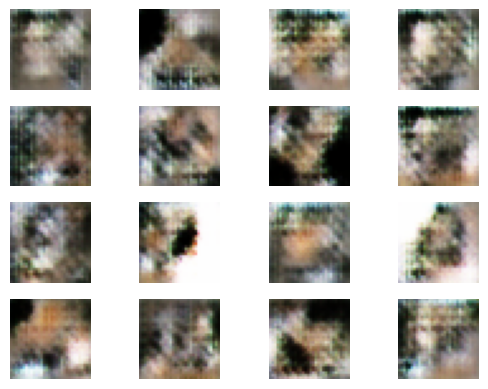

Time for epoch 76 is 4.654461860656738 sec
Epoch 77, Iteration 1/47, D_loss = 1.168, G_loss = 0.830
Epoch 77, Iteration 2/47, D_loss = 1.158, G_loss = 0.851
Epoch 77, Iteration 3/47, D_loss = 1.131, G_loss = 0.856
Epoch 77, Iteration 4/47, D_loss = 1.170, G_loss = 0.870
Epoch 77, Iteration 5/47, D_loss = 1.150, G_loss = 0.852
Epoch 77, Iteration 6/47, D_loss = 1.163, G_loss = 0.802
Epoch 77, Iteration 7/47, D_loss = 1.155, G_loss = 0.800
Epoch 77, Iteration 8/47, D_loss = 1.200, G_loss = 0.872
Epoch 77, Iteration 9/47, D_loss = 1.147, G_loss = 0.912
Epoch 77, Iteration 10/47, D_loss = 1.210, G_loss = 0.882
Epoch 77, Iteration 11/47, D_loss = 1.215, G_loss = 0.856
Epoch 77, Iteration 12/47, D_loss = 1.219, G_loss = 0.846
Epoch 77, Iteration 13/47, D_loss = 1.242, G_loss = 0.867
Epoch 77, Iteration 14/47, D_loss = 1.229, G_loss = 0.856
Epoch 77, Iteration 15/47, D_loss = 1.175, G_loss = 0.876
Epoch 77, Iteration 16/47, D_loss = 1.206, G_loss = 0.973
Epoch 77, Iteration 17/47, D_loss = 1.

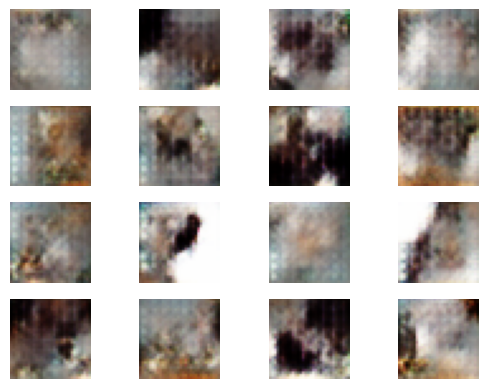

Time for epoch 81 is 4.784543037414551 sec
Epoch 82, Iteration 1/47, D_loss = 1.260, G_loss = 0.748
Epoch 82, Iteration 2/47, D_loss = 1.249, G_loss = 0.702
Epoch 82, Iteration 3/47, D_loss = 1.212, G_loss = 0.678
Epoch 82, Iteration 4/47, D_loss = 1.198, G_loss = 0.683
Epoch 82, Iteration 5/47, D_loss = 1.112, G_loss = 0.777
Epoch 82, Iteration 6/47, D_loss = 1.129, G_loss = 0.768
Epoch 82, Iteration 7/47, D_loss = 1.108, G_loss = 0.778
Epoch 82, Iteration 8/47, D_loss = 1.170, G_loss = 0.746
Epoch 82, Iteration 9/47, D_loss = 1.162, G_loss = 0.752
Epoch 82, Iteration 10/47, D_loss = 1.126, G_loss = 0.802
Epoch 82, Iteration 11/47, D_loss = 1.188, G_loss = 0.817
Epoch 82, Iteration 12/47, D_loss = 1.237, G_loss = 0.802
Epoch 82, Iteration 13/47, D_loss = 1.288, G_loss = 0.818
Epoch 82, Iteration 14/47, D_loss = 1.388, G_loss = 0.811
Epoch 82, Iteration 15/47, D_loss = 1.397, G_loss = 0.770
Epoch 82, Iteration 16/47, D_loss = 1.366, G_loss = 0.783
Epoch 82, Iteration 17/47, D_loss = 1.

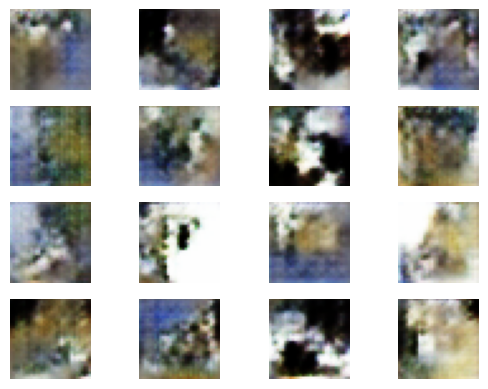

Time for epoch 86 is 4.731675863265991 sec
Epoch 87, Iteration 1/47, D_loss = 1.117, G_loss = 0.846
Epoch 87, Iteration 2/47, D_loss = 1.121, G_loss = 0.877
Epoch 87, Iteration 3/47, D_loss = 1.110, G_loss = 0.926
Epoch 87, Iteration 4/47, D_loss = 1.140, G_loss = 0.859
Epoch 87, Iteration 5/47, D_loss = 1.148, G_loss = 0.811
Epoch 87, Iteration 6/47, D_loss = 1.149, G_loss = 0.817
Epoch 87, Iteration 7/47, D_loss = 1.206, G_loss = 0.869
Epoch 87, Iteration 8/47, D_loss = 1.256, G_loss = 0.824
Epoch 87, Iteration 9/47, D_loss = 1.245, G_loss = 0.795
Epoch 87, Iteration 10/47, D_loss = 1.223, G_loss = 0.784
Epoch 87, Iteration 11/47, D_loss = 1.229, G_loss = 0.803
Epoch 87, Iteration 12/47, D_loss = 1.203, G_loss = 0.830
Epoch 87, Iteration 13/47, D_loss = 1.173, G_loss = 0.800
Epoch 87, Iteration 14/47, D_loss = 1.214, G_loss = 0.840
Epoch 87, Iteration 15/47, D_loss = 1.310, G_loss = 0.876
Epoch 87, Iteration 16/47, D_loss = 1.193, G_loss = 0.887
Epoch 87, Iteration 17/47, D_loss = 1.

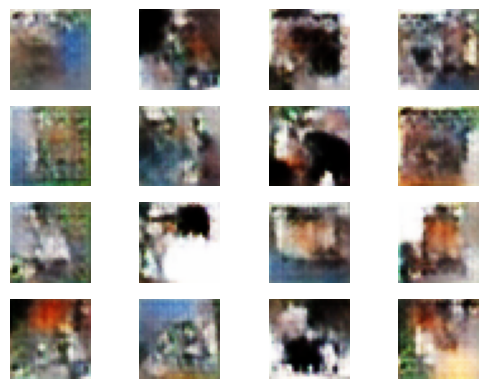

Time for epoch 91 is 4.676187753677368 sec
Epoch 92, Iteration 1/47, D_loss = 1.479, G_loss = 0.723
Epoch 92, Iteration 2/47, D_loss = 1.413, G_loss = 0.680
Epoch 92, Iteration 3/47, D_loss = 1.406, G_loss = 0.707
Epoch 92, Iteration 4/47, D_loss = 1.420, G_loss = 0.718
Epoch 92, Iteration 5/47, D_loss = 1.423, G_loss = 0.705
Epoch 92, Iteration 6/47, D_loss = 1.391, G_loss = 0.721
Epoch 92, Iteration 7/47, D_loss = 1.391, G_loss = 0.728
Epoch 92, Iteration 8/47, D_loss = 1.358, G_loss = 0.727
Epoch 92, Iteration 9/47, D_loss = 1.279, G_loss = 0.752
Epoch 92, Iteration 10/47, D_loss = 1.188, G_loss = 0.796
Epoch 92, Iteration 11/47, D_loss = 1.170, G_loss = 0.813
Epoch 92, Iteration 12/47, D_loss = 1.143, G_loss = 0.810
Epoch 92, Iteration 13/47, D_loss = 1.137, G_loss = 0.867
Epoch 92, Iteration 14/47, D_loss = 1.101, G_loss = 0.948
Epoch 92, Iteration 15/47, D_loss = 1.169, G_loss = 0.864
Epoch 92, Iteration 16/47, D_loss = 1.172, G_loss = 0.918
Epoch 92, Iteration 17/47, D_loss = 1.

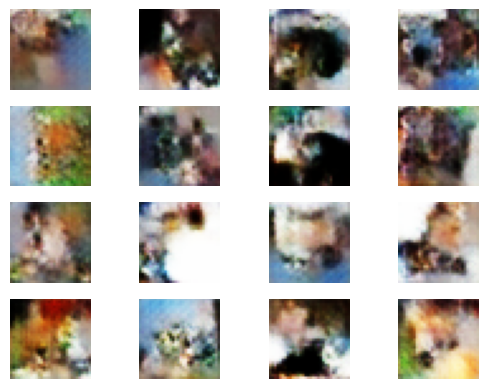

Time for epoch 96 is 4.6810290813446045 sec
Epoch 97, Iteration 1/47, D_loss = 1.382, G_loss = 0.709
Epoch 97, Iteration 2/47, D_loss = 1.379, G_loss = 0.694
Epoch 97, Iteration 3/47, D_loss = 1.391, G_loss = 0.675
Epoch 97, Iteration 4/47, D_loss = 1.413, G_loss = 0.691
Epoch 97, Iteration 5/47, D_loss = 1.410, G_loss = 0.715
Epoch 97, Iteration 6/47, D_loss = 1.410, G_loss = 0.715
Epoch 97, Iteration 7/47, D_loss = 1.451, G_loss = 0.673
Epoch 97, Iteration 8/47, D_loss = 1.441, G_loss = 0.704
Epoch 97, Iteration 9/47, D_loss = 1.474, G_loss = 0.670
Epoch 97, Iteration 10/47, D_loss = 1.424, G_loss = 0.705
Epoch 97, Iteration 11/47, D_loss = 1.452, G_loss = 0.714
Epoch 97, Iteration 12/47, D_loss = 1.476, G_loss = 0.705
Epoch 97, Iteration 13/47, D_loss = 1.428, G_loss = 0.708
Epoch 97, Iteration 14/47, D_loss = 1.423, G_loss = 0.730
Epoch 97, Iteration 15/47, D_loss = 1.417, G_loss = 0.695
Epoch 97, Iteration 16/47, D_loss = 1.424, G_loss = 0.712
Epoch 97, Iteration 17/47, D_loss = 1

In [20]:
# Hàm huấn luyện
def train(dataset, epochs):
    d_loss_values = []  # Lưu trữ d_loss của tất cả các epoch
    g_loss_values = []  # Lưu trữ g_loss của tất cả các epoch

    for epoch in range(epochs):
        start = time.time()

        i = 0
        bat_per_epo = len(dataset)
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

            # In ra thông tin về tiến trình
            print(f'Epoch {epoch+1}, Iteration {i+1}/{bat_per_epo}, D_loss = {disc_loss:.3f}, G_loss = {gen_loss:.3f}')
            
            # Lưu các giá trị loss
            d_loss_values.append(disc_loss)
            g_loss_values.append(gen_loss)
            i += 1

        if epoch % PRINT_EPOCH == 0:
            generate_and_save_images(generator,
                                     epoch + 1,
                                     tf.random.normal([num_examples_to_generate, noise_dim]))

        print(f'Time for epoch {epoch+1} is {time.time()-start} sec')
    return d_loss_values, g_loss_values
d_loss_values, g_loss_values = train(train_dataset, EPOCHS)


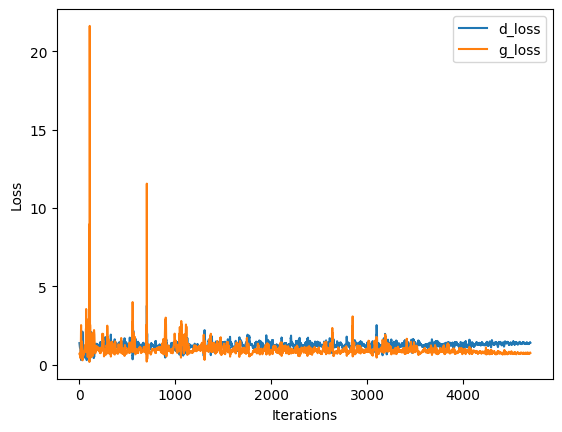

In [21]:
def plot_loss(d_loss_values, g_loss_values):
    # Khởi tạo giá trị của trục x (iterations)
    dx = np.linspace(0, len(d_loss_values), len(d_loss_values))
    gx = np.linspace(0, len(g_loss_values), len(g_loss_values))

    # Vẽ biểu đồ loss của G và D
    plt.plot(dx, d_loss_values)
    plt.plot(gx, g_loss_values)
    plt.ylabel('Loss')
    plt.xlabel('Iterations')
    plt.legend(['d_loss', 'g_loss'], loc='upper right')
    plt.show()
    
plot_loss(d_loss_values, g_loss_values)